# Model Evaluation
**Author**: Johannes S. Fischer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

from ModelGenerator import get_base_model2

from Dataloader import load_FERplus_targetvector
from Dataloader import load_RAF_targetvector

from sklearn import metrics

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# function to turn imagedatagenerator set into tensors
def get_tensors(datagen):
    datagen.reset()
    
    X, Y = [], []
    batch_idx = 0
    while batch_idx <= datagen.batch_index:
        data = datagen.next()
        if len(X) == 0:
            X.append(data[0])
            X = np.array(np.squeeze(X))

            Y.append(data[1])
            Y = np.array(np.squeeze(Y))
        else:
            X = np.concatenate((X, data[0]), axis=0)
            Y = np.concatenate((Y, data[1]), axis=0)
        batch_idx += 1

    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

## Load Model

In [3]:
def vec2label(onehot_vec, emotion_labels):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

IMG_SHAPE = (100, 100, 3)

models = {
    'raf': {
        'name': 'RAF'
    },
    'fer': {
        'name': 'FER'
    }
}

### RAF

In [4]:
def preprocess_raf(x):
    mean = [146.6770, 114.6274, 102.3102]
    std = [67.6282, 61.7651, 61.3665]
    # ensure image format
    x = np.array(x, dtype='float32')
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

LABELS_RAF = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']

# model
model_name = 'RAF-impr-std_0124-1008_weights.h5'
model_raf = get_base_model2(IMG_SHAPE)
model_raf.add(tf.keras.layers.Dense(7, activation='softmax', name="softmax"))
model_raf.load_weights('./models/' + model_name)

model_raf.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

models['raf']['model'] = model_raf
models['raf']['labels'] = LABELS_RAF
models['raf']['preprocess'] = preprocess_raf

### FER+

In [5]:
# FERplus 2013 preprocessing function
def preprocess_fer(x):
    mean = [129.4432, 129.4432, 129.4432]
    std = [64.87448751, 64.87448751, 64.87448751]
    # ensure image format
    x = np.array(x, dtype='float32')
    
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

LABELS_FER = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

# model
model_name = 'FERplus-impr-std_0124-1040_weights.h5'
model_fer = get_base_model2(IMG_SHAPE)
model_fer.add(tf.keras.layers.Dense(7, activation='softmax', name="softmax"))
model_fer.load_weights('./models/' + model_name)

model_fer.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

models['fer']['model'] = model_fer
models['fer']['labels'] = LABELS_FER
models['fer']['preprocess'] = preprocess_fer

# Data

### RAF-DB

In [6]:
%%time
# RAF-DB data
train_raf, val_raf, test_raf = load_RAF_targetvector('./data/RAF/',
                                                     target_img_size=IMG_SHAPE[:2],
                                                     batch_size=64,
                                                     preprocessing_function=preprocess_raf)

Splitting testing dataset into stratified validation and training set
Training
- (12271, 100, 100, 3) 
- (12271, 7)
Validation
- (1534, 100, 100, 3) 
- (1534, 7)
Testing
- (1534, 100, 100, 3) 
- (1534, 7)
Wall time: 14.5 s


### FER+

In [7]:
%%time
# FERplus data
train_fer, val_fer, test_fer = load_FERplus_targetvector('./data/ferplus2013/',
                                                         target_img_size=IMG_SHAPE[:2],
                                                         batch_size=64,
                                                         preprocessing_function=preprocess_fer)

Training
- (28557, 100, 100, 3) 
- (28557, 7)
Validation
- (3573, 100, 100, 3) 
- (3573, 7)
Testing
- (3579, 100, 100, 3) 
- (3579, 7)
Wall time: 50.3 s


# RAF-DB model

In [8]:
model = models['raf']
data_test = test_raf
data_val = val_raf

### Accuracies

In [9]:
# get tensors of test dataset
X, Y = get_tensors(data_test)
Y_logits = np.argmax(Y, axis=1)

preds = model['model'].predict(X)

Yhat = np.argmax(preds, axis=1)

print("Test Accuracy:\t{:.2f}%".format(100*(Y_logits == Yhat).sum() / Yhat.size))
print("Metrics:\n", metrics.classification_report(y_true=Y_logits, y_pred=Yhat, target_names=model['labels']))

Test Accuracy:	82.72%
Metrics:
               precision    recall  f1-score   support

    surprise       0.92      0.79      0.85       165
        fear       0.81      0.46      0.59        37
     disgust       0.76      0.31      0.44        80
   happiness       0.94      0.88      0.91       592
     sadness       0.83      0.82      0.83       239
       anger       0.80      0.74      0.77        81
     neutral       0.67      0.93      0.78       340

    accuracy                           0.83      1534
   macro avg       0.82      0.71      0.74      1534
weighted avg       0.84      0.83      0.82      1534



In [10]:
# validation accuracy
model['val'] = {}
model['val']['loss'], model['val']['acc'] = model['model'].evaluate(data_val)

print(f"\n-- Validation {model['name']}")
print("Accuracy:\t%.2f%%" % (model['val']['acc'] * 100))
print("Loss:\t\t%.4f" % (model['val']['loss']))

24/24 [==============================] - 17s 92ms/step - loss: 0.8965 - accuracy: 0.8299

-- Validation RAF
Accuracy:	82.99%
Loss:		0.8965


In [11]:
# test accuracy for RAF-DB model
model['test'] = {}
model['test']['loss'], model['test']['acc'] = model['model'].evaluate(data_test)

print(f"\n-- Test {model['name']}")
print("Accuracy:\t%.2f%%" % (model['test']['acc'] * 100))
print("Loss:\t\t%.4f" % (model['test']['loss']))

24/24 [==============================] - 15s 68ms/step - loss: 0.8981 - accuracy: 0.82720s - loss: 0.876

-- Test RAF
Accuracy:	82.72%
Loss:		0.8981


### Confusion matrix

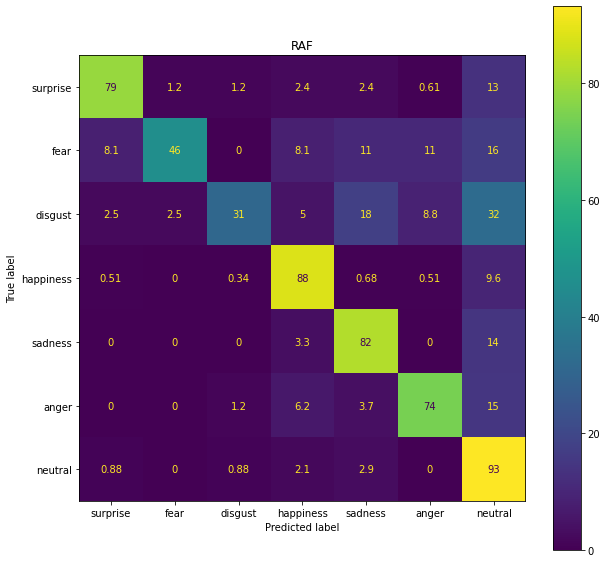

In [12]:
conf_matrix = metrics.confusion_matrix(Y_logits, Yhat, normalize='true')
disp = metrics.ConfusionMatrixDisplay(conf_matrix*100, display_labels=model['labels'])
plt.figure(figsize=(10,10))
ax = plt.axes()
disp.plot(ax=ax)
plt.title(model['name'])
plt.savefig('./results/conf-matrix-{}.png'.format(model['name']), dpi=300, bbox_inches='tight')
plt.show()

<br></br>

----------------

# FER+ model

In [13]:
model = models['fer']
data_test = test_fer
data_val = val_fer

### Accuracies

In [14]:
# get tensors of test dataset
X, Y = get_tensors(data_test)
Y_logits = np.argmax(Y, axis=1)

preds = model['model'].predict(X)

Yhat = np.argmax(preds, axis=1)

print("Test Accuracy:\t{:.2f}%".format(100*(Y_logits == Yhat).sum() / Yhat.size))
print("Metrics:\n", metrics.classification_report(y_true=Y_logits, y_pred=Yhat, target_names=model['labels']))

Test Accuracy:	83.77%
Metrics:
               precision    recall  f1-score   support

     neutral       0.85      0.86      0.85      1359
   happiness       0.90      0.94      0.92       900
    surprise       0.85      0.89      0.87       461
     sadness       0.70      0.65      0.67       423
       anger       0.79      0.78      0.79       322
     disgust       0.67      0.31      0.42        39
        fear       0.72      0.52      0.60        75

    accuracy                           0.84      3579
   macro avg       0.78      0.71      0.73      3579
weighted avg       0.83      0.84      0.83      3579



In [15]:
# validation accuracy
model['val'] = {}
model['val']['loss'], model['val']['acc'] = model['model'].evaluate(data_val)

print(f"\n-- Validation {model['name']}")
print("Accuracy:\t%.2f%%" % (model['val']['acc'] * 100))
print("Loss:\t\t%.4f" % (model['val']['loss']))

56/56 [==============================] - 18s 74ms/step - loss: 0.7637 - accuracy: 0.8421

-- Validation FER
Accuracy:	84.21%
Loss:		0.7637


In [16]:
# test accuracy for RAF-DB model
model['test'] = {}
model['test']['loss'], model['test']['acc'] = model['model'].evaluate(data_test)

print(f"\n-- Test {model['name']}")
print("Accuracy:\t%.2f%%" % (model['test']['acc'] * 100))
print("Loss:\t\t%.4f" % (model['test']['loss']))

56/56 [==============================] - 17s 75ms/step - loss: 0.7295 - accuracy: 0.8377

-- Test FER
Accuracy:	83.77%
Loss:		0.7295


### Confusion matrix

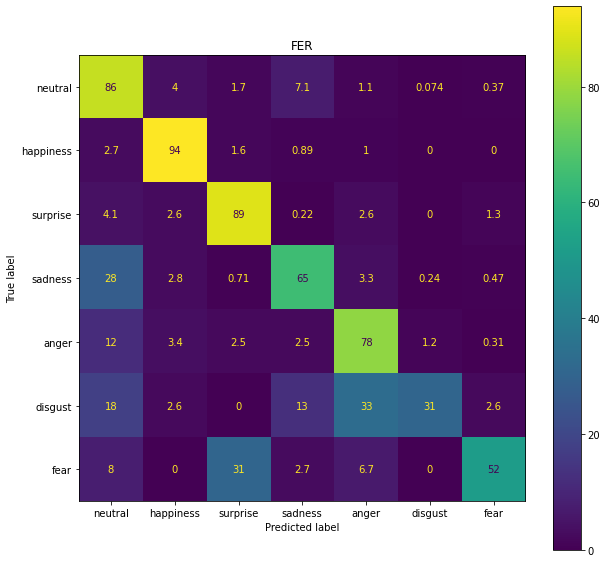

In [17]:
conf_matrix = metrics.confusion_matrix(Y_logits, Yhat, normalize='true')
disp = metrics.ConfusionMatrixDisplay(conf_matrix*100, display_labels=model['labels'])
plt.figure(figsize=(10,10))
ax = plt.axes()
disp.plot(ax=ax)
plt.title(model['name'])
plt.savefig('./results/conf-matrix-{}.png'.format(model['name']), dpi=300, bbox_inches='tight')
plt.show()

---